# Predicciones de la calidad del vino usando redes neuronales

Ahora viene la parte para nosotros mas interesante, en la cual compararemos diferentes configuraciones de redes neuronales para hacer prediccciones de la calidad del vino, esta vez considerando tambien el color

# instalacion e importacion de librerias y datos:

In [26]:
!pip install keras
!pip install tensorflow
!pip install ucimlrepo
!pip install seaborn
!pip install scikit-learn
!pip install pydot

**IMPORTANTE:DADO QUE TENSORFLOW AUN NO ESTA DISPONIBLE PARA LA VERSION 3.13 DE PYTHON, ESTE NOTEBOOK HA SIDO CREADO DESDE UN ENTORNO VIRTUAL DE ANACONDA, CON LA VERSION 3.10, SI DA ERRORES AL EJECUTAR, CONTACTAR CON LOS DESARROLLADORES**

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv1D, MaxPooling1D, Flatten, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
import sys
print(sys.version)


3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]


In [4]:
wine_quality = fetch_ucirepo(name="Wine Quality")
dataset = wine_quality.data.original

**¿Por qué usar la semilla?**

Durante el entrenamiento de modelos de Machine Learning y redes neuronales, muchos procesos dependen de números aleatorios, como la inicialización de los pesos de la red, el orden de los datos durante el entrenamiento, etc. Si no estableces una semilla, podrías obtener diferentes resultados en cada ejecución. Al fijar una semilla, se asegura que la secuencia de números aleatorios será siempre la misma, lo que permite comparar modelos de manera consistente y reproducible.

In [5]:
# Setting Keras seed so results are reproducible

keras.utils.set_random_seed(49)

# EDA

observamos un poco las columnas y filas del dataset

In [6]:
dataset

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


no hay valores nulos en el dataset, los tipos de dato son float de 64 bits y enteros de 64 bit

In [8]:
print("Number of Duplicates in dataset:",dataset.duplicated().sum())
print("Duplicated targets:\n", dataset[dataset.duplicated()]["quality"].value_counts())

Number of Duplicates in dataset: 1177
Duplicated targets:
 quality
6    513
5    386
7    223
8     45
4     10
Name: count, dtype: int64


vemos que hay valores duplicados, decidimos que permanezcan ya que son diferentes observaciones que con distintos parametros relacionados con el vino hacen variar su calidad

a continuacion observamos que valores numericos hay y cuales hay que sean categoricos. En este caso puede parecer obvio porque solo hay una columna con datos que no son numericos como puede ser el color, sin embargo el codigo debe ser aplicable a todos los casos, asi pues este codigo funciona para este dataset "sencillo" como para un dataset de 1000 columnas 

In [9]:
minModalities = 7 ## To match dataset desciprtion on UCI website, numerical variables with less than 7 modalities are considered as nominal

def getCategFeat(df, n, target):
    return [c for c in df.columns if (df[c].dtype == 'O' or df[c].nunique()<n) and c!=target]

categorical_features = getCategFeat(dataset,minModalities,'quality')

print("Categorical Features : ",categorical_features)
numerical_features = [c for c in dataset.columns if c not in categorical_features and c!="quality"]
print("Numerical Features : ", numerical_features)

output_variable = ['quality']

Categorical Features :  ['color']
Numerical Features :  ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


Ahora vamos a observar la distribucion de probabilidad de la calidad, como podemos ver, tanto para el vino tinto como para el vino blanco , las calidades suelen tener como valor esperado 5 o 6

C:\Users\User\AppData\Local\Temp\ipykernel_11436\3256744394.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[(dataset.color == 'red')]["quality"],color='c',ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_11436\3256744394.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[(d

Text(0.5, 1.0, 'Distribution of quality for white wine')

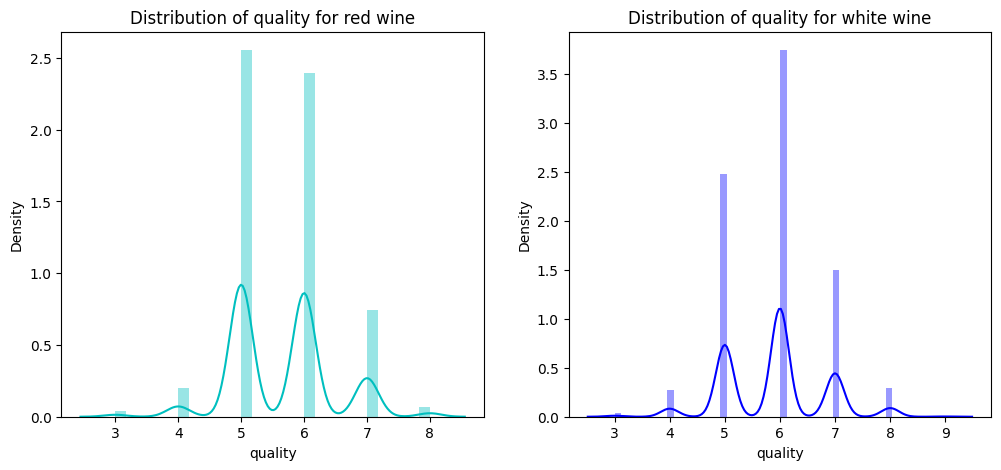

In [10]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(dataset[(dataset.color == 'red')]["quality"],color='c',ax=ax)
ax.set_title('Distribution of quality for red wine')

ax=f.add_subplot(122)
sns.distplot(dataset[(dataset.color == 'white')]['quality'],color='b',ax=ax)
ax.set_title('Distribution of quality for white wine')

**Observaciones clave - Datos desbalanceados**

- **Tendencia central**: Ambos gráficos muestran que la mayoría de los vinos tienen una puntuación alrededor de 5 o 6, siendo esto especialmente pronunciado en los vinos blancos.

- **Dispersión y sesgo**: Las puntuaciones de los vinos rojos tienen una distribución dispersa con varios picos, lo que sugiere que las calificaciones de calidad para los vinos rojos son más variadas. Las puntuaciones de los vinos blancos están más sesgadas hacia la puntuación de 6, mostrando una mayor concentración de vinos blancos calificados con esta calidad.

- **Extremos**: Hay menos casos de calificaciones de calidad muy altas o muy bajas tanto para los vinos rojos como para los blancos.

- **Comparación entre vino tinto y vino blanco**: Los vinos blancos tienen un pico más alto en la puntuación de calidad de 6, mientras que los vinos rojos tienen una distribución más uniforme de las calificaciones de calidad alrededor de 5 y 6, lo que indica una concentración menos pronunciada en comparación con los vinos blancos.

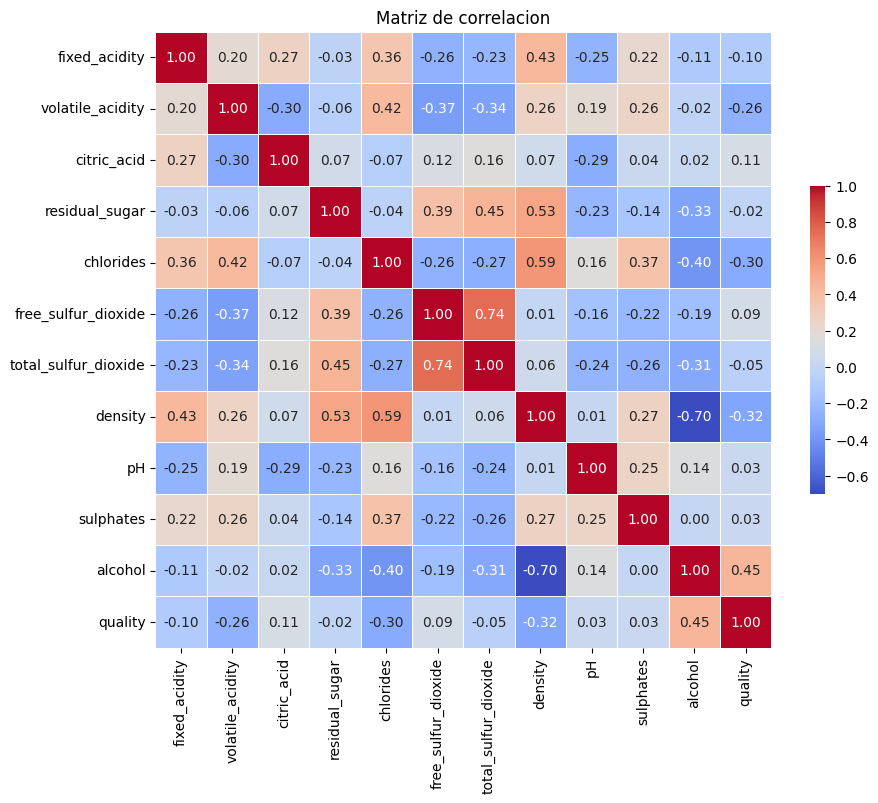

In [11]:
dataset_correlations = dataset.corr(method='spearman', numeric_only = True)
plt.figure(figsize=(10, 8))

sns.heatmap(dataset_correlations, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Matriz de correlacion')
plt.show()

de nuevo vemos las mismas relaciones que en el notebook de gradient Boodsting.

A continuacion hay que modificar los atributos que no son numericos, para ello definiremos una columna de manera que si el vino es rojo, este valor se suplantara por un 1 y si el vino es blanco por un 0

In [12]:
dataset['color_binary'] = np.where(dataset['color'] =='red', 1, 0)
dataset.drop(columns=['color'], inplace=True)
dataset.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


escalamos los datos de manera que cada caracteristica tenga el mismo peso

In [15]:
continuous_data = dataset[numerical_features]
std_scalar = StandardScaler().fit(continuous_data)
std_continuous_data = std_scalar.transform(continuous_data)

categorical_data = dataset['color_binary'].to_numpy().reshape(-1,1)

In [16]:
# Creamos la variable objetivo y las características

y = dataset['quality'] # variable objetivo
y_adjusted = y-3 # las puntuaciones van de 3 a 9, para asegurar 7 clases y usar to-categorical, restamos tres para que ahora esté en el rango de 0 a 6
y = to_categorical(y_adjusted, num_classes=7)
x = np.append(categorical_data, std_continuous_data, axis=1)
print(x.shape)
print(y.shape)


(6497, 12)
(6497, 7)


creamos el conjunto de train, test y reducimos el tamaño de la representacion de los numeros de 64 bits a 32 para mejorar el coste computacional (se dispone de un buen ordenador pero no de los servidores de OpneAI)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

print(x_train.shape)
print(y_train.shape)

(4547, 12)
(4547, 7)


creamos una funcion para representar la curva de aprendizaje de nuestro modelo 

In [19]:
def plot_history(model):
  plt.figure(figsize=(10,5))
  plt.plot(model.history['accuracy'], label = 'Training Accuracy')
  plt.plot(model.history['val_accuracy'], label = 'Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs Epochs ')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(model.history['loss'], label = 'Training Loss')
  plt.plot(model.history['val_loss'], label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs Epochs ')
  plt.legend()
  plt.show()

  print(f'The layers of the model:')
  for layer in history.model.layers:
    print(str(layer)[18:])

  print("----------------------------------------------------\n")
  return

## En primer lugar: construiremos un modelo sencillo con una sola capa, de esta manera veremos que tal hacemos predicciones sin necesidad de recurrir al deep learning

la red neuronal diseñada tiene:
* **una capa de entrada InputLayer()**
* **una capa densa Dense() de 7 neuronas**

In [20]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

C:\Users\User\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/200
143/143 - 3s - 20ms/step - accuracy: 0.1416 - loss: 2.2666 - val_accuracy: 0.1851 - val_loss: 2.0729
Epoch 2/200
143/143 - 1s - 6ms/step - accuracy: 0.2336 - loss: 1.9208 - val_accuracy: 0.2826 - val_loss: 1.7996
Epoch 3/200
143/143 - 1s - 10ms/step - accuracy: 0.3290 - loss: 1.6979 - val_accuracy: 0.3615 - val_loss: 1.6195
Epoch 4/200
143/143 - 1s - 9ms/step - accuracy: 0.4005 - loss: 1.5463 - val_accuracy: 0.4210 - val_loss: 1.4934
Epoch 5/200
143/143 - 1s - 9ms/step - accuracy: 0.4451 - loss: 1.4375 - val_accuracy: 0.4497 - val_loss: 1.4010
Epoch 6/200
143/143 - 1s - 9ms/step - accuracy: 0.4713 - loss: 1.3568 - val_accuracy: 0.4805 - val_loss: 1.3319
Epoch 7/200
143/143 - 1s - 9ms/step - accuracy: 0.4907 - loss: 1.2962 - val_accuracy: 0.4974 - val_loss: 1.2798
Epoch 8/200
143/143 - 1s - 9ms/step - accuracy: 0.5063 - loss: 1.2503 - val_accuracy: 0.5041 - val_loss: 1.2402
Epoch 9/200
143/143 - 1s - 9ms/step - accuracy: 0.5190 - loss: 1.2153 - val_accuracy: 0.5118 - val_los

Vemos que podemos llegar como mucho a un accuracy del 0.54 en el epoch 128

**observacion:** con 30 epochs mas o menos hubiera sido suficiente para entrenar el modelo, no hay una notable mejora a partir de este como veremos en las curvas de aprendizaje 

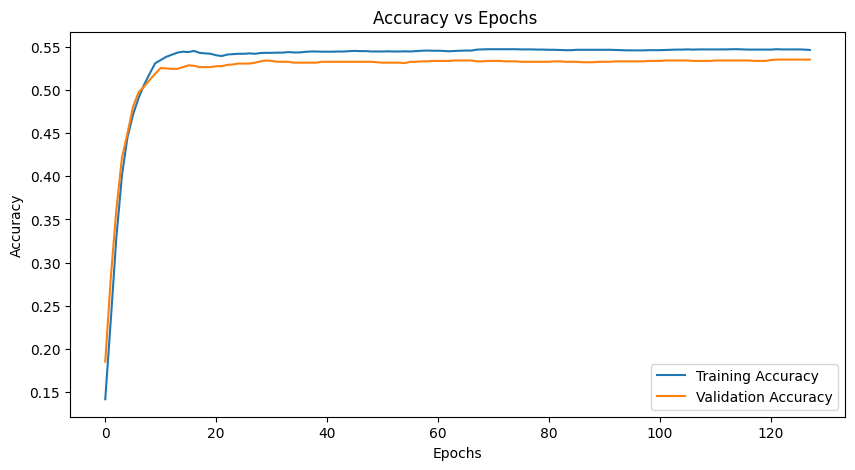

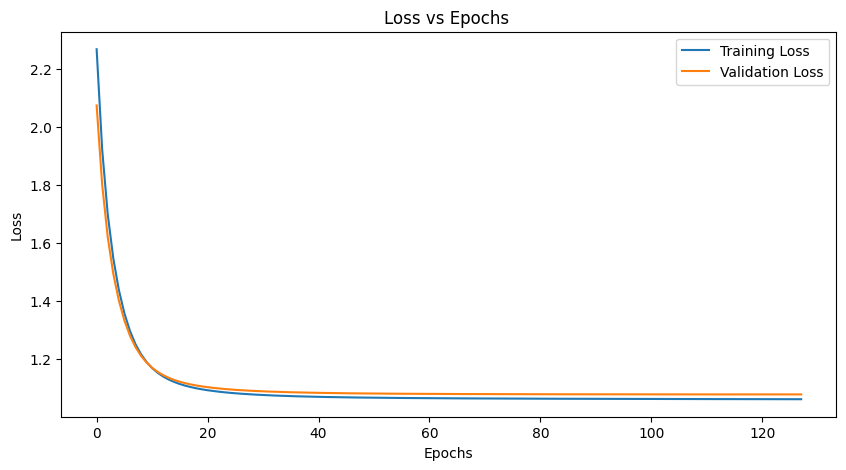

The layers of the model:
 built=True>
----------------------------------------------------



In [21]:
plot_history(history)

Como se puede apreciar en las curvas de aprendizage, no hay simbolos de overfitting

## En segundo lugar: vamos a añadir una caoa mas al modelo, ahora ya estamos en el mundo del deep learning. Veamos que tal reacciona el modelo

La red neuronal tiene:
* **Una capa de entrada InputLayer()**
* **Una capa densa Dense() de 256 neuronas con funcion de activacion relu**
* **Una capa densa Dense() de 7 neuronas con funcion de activacion softmax ideal para determinar la prediccion de una clase** 

**Recordatorio:** El enfoque que se le esta dando a este problema difiere de los anteriores: antes haciamos una regresion pura y dura, notese que ahora lo que estamos haciendo es establecer 7 clases una para cada calidad posible de vino. De la neurona de "salida" que se active hay que sumarle un offset. Si por ejemplo nos sale la neurona en la posicion 1 quiere decir que el vino tendra una calidad de 4. 

Asi pues se destaca el hecho que la perspectiva es mas una clasificacion que una regresion como tal.

In [22]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=256, activation="relu"),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
143/143 - 3s - 20ms/step - accuracy: 0.5019 - loss: 1.2641 - val_accuracy: 0.5487 - val_loss: 1.1124
Epoch 2/200
143/143 - 1s - 7ms/step - accuracy: 0.5553 - loss: 1.0847 - val_accuracy: 0.5549 - val_loss: 1.0836
Epoch 3/200
143/143 - 1s - 9ms/step - accuracy: 0.5606 - loss: 1.0568 - val_accuracy: 0.5579 - val_loss: 1.0714
Epoch 4/200
143/143 - 1s - 9ms/step - accuracy: 0.5654 - loss: 1.0416 - val_accuracy: 0.5579 - val_loss: 1.0633
Epoch 5/200
143/143 - 1s - 8ms/step - accuracy: 0.5659 - loss: 1.0306 - val_accuracy: 0.5600 - val_loss: 1.0576
Epoch 6/200
143/143 - 1s - 9ms/step - accuracy: 0.5687 - loss: 1.0216 - val_accuracy: 0.5579 - val_loss: 1.0528
Epoch 7/200
143/143 - 1s - 10ms/step - accuracy: 0.5705 - loss: 1.0138 - val_accuracy: 0.5579 - val_loss: 1.0488
Epoch 8/200
143/143 - 1s - 9ms/step - accuracy: 0.5753 - loss: 1.0071 - val_accuracy: 0.5595 - val_loss: 1.0453
Epoch 9/200
143/143 - 1s - 8ms/step - accuracy: 0.5766 - loss: 1.0007 - val_accuracy: 0.5615 - val_los

vemos una clara mejora en el accuracy ya que partimos directamente de un accuracy de 0.5019 mientras que con una sola capa empezabamos con un accuracy de 0.14

Con la adicion de una capa conseguimos un accuracy de 0.6 y ademas con menos epochs

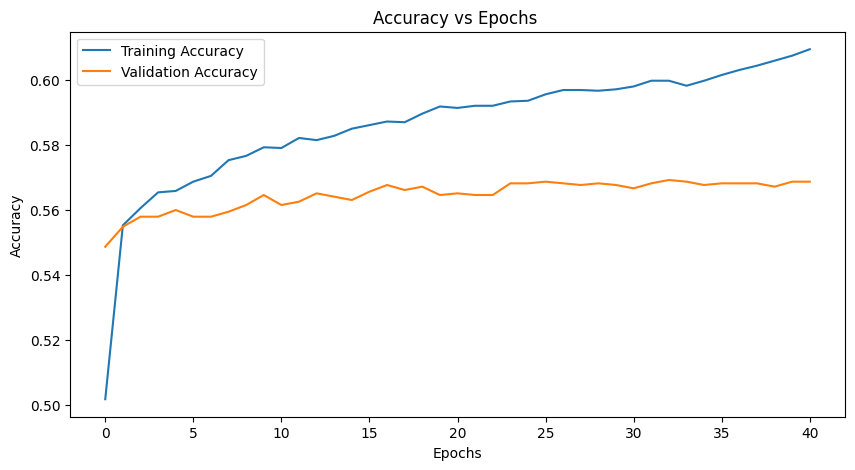

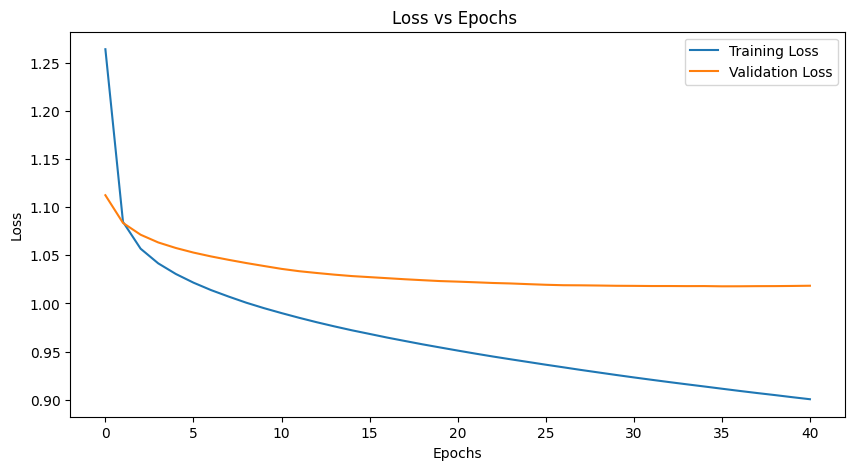

The layers of the model:
1, built=True>
2, built=True>
----------------------------------------------------



In [23]:
plot_history(history)

No hay simbolos de overfitting

## EN tercer lugar: Ahora hacemos un modelo con otra capa mas pero con una forma mas de "funnel"

La red se compone de:
* **capa de entrada**
* **capa densa con 128 neuronas y funcion de activacion ReLu**
* **capa densa con 64 neuronas y funcion de activacion ReLu**
* **capa de de salida con activacion softmax, ideal para hacer predicciones sobre clases**

In [29]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=128, activation="relu"),
    Dense(units=64, activation="relu"),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
143/143 - 4s - 25ms/step - accuracy: 0.4874 - loss: 1.2735 - val_accuracy: 0.5333 - val_loss: 1.1235
Epoch 2/200
143/143 - 2s - 15ms/step - accuracy: 0.5536 - loss: 1.0860 - val_accuracy: 0.5544 - val_loss: 1.0885
Epoch 3/200
143/143 - 1s - 9ms/step - accuracy: 0.5667 - loss: 1.0529 - val_accuracy: 0.5569 - val_loss: 1.0736
Epoch 4/200
143/143 - 1s - 6ms/step - accuracy: 0.5698 - loss: 1.0343 - val_accuracy: 0.5559 - val_loss: 1.0639
Epoch 5/200
143/143 - 1s - 7ms/step - accuracy: 0.5703 - loss: 1.0197 - val_accuracy: 0.5585 - val_loss: 1.0569
Epoch 6/200
143/143 - 1s - 7ms/step - accuracy: 0.5716 - loss: 1.0079 - val_accuracy: 0.5585 - val_loss: 1.0521
Epoch 7/200
143/143 - 1s - 10ms/step - accuracy: 0.5764 - loss: 0.9970 - val_accuracy: 0.5641 - val_loss: 1.0467
Epoch 8/200
143/143 - 1s - 9ms/step - accuracy: 0.5793 - loss: 0.9873 - val_accuracy: 0.5615 - val_loss: 1.0433
Epoch 9/200
143/143 - 1s - 9ms/step - accuracy: 0.5806 - loss: 0.9779 - val_accuracy: 0.5595 - val_lo

**IMPRESIONANTE:** Con tan solo 18 Epochs conseguimos un accuracy del 0.61, en muchisimas menos epochs que los dos modelos anteriores y ademas es el que mas accuracy tiene

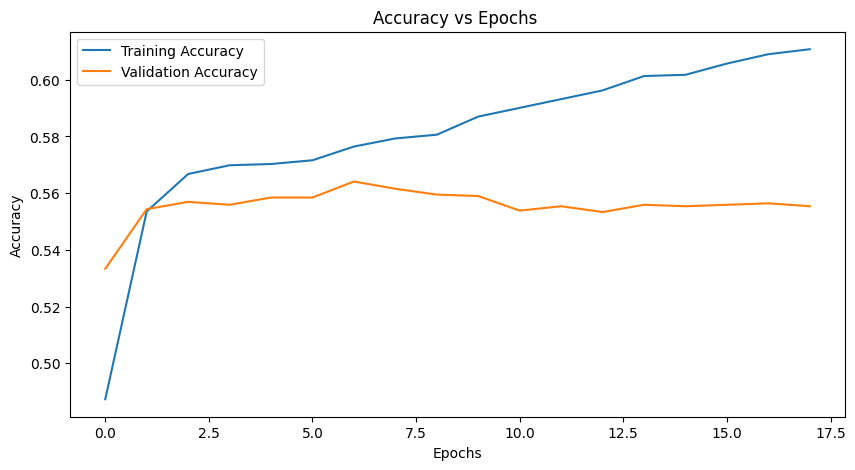

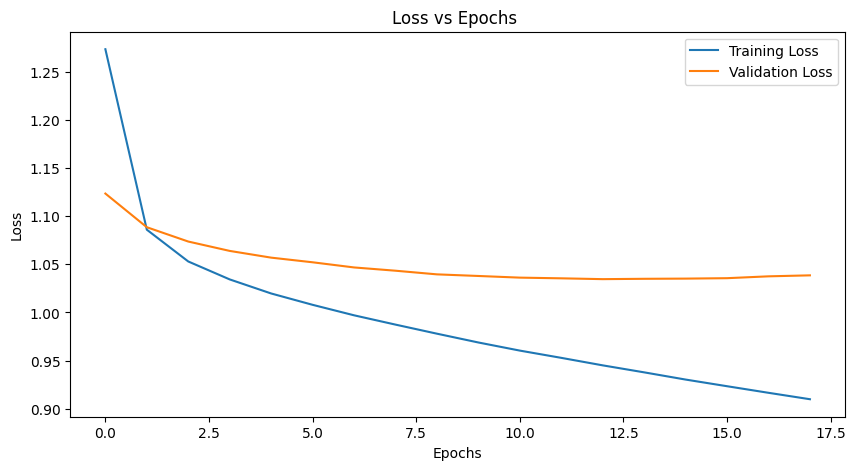

The layers of the model:
3, built=True>
4, built=True>
5, built=True>
----------------------------------------------------



In [30]:
plot_history(history)

# Conclusiones y posibles mejoras

El accuracy de 0.61 conseguido es considerablemente bueno. En otros proyectos consultados se consigue un accuracy validation de hasta 0,71 esto lo consiguen entrenando dos modelos diferentes en funcion de si el vino es blanco o rojo. En nuestro trabajo hemos entrenado el mismo modelo para ambos casos. Porque se obtienen mejores resultados al dividir ambas partes?

1. **Diferencias en las características de los vinos rojos y blancos:**
Los vinos rojos y blancos, aunque puedan compartir algunas características generales (como pH, acidez, azúcar, etc.), tienen diferencias inherentes en sus composiciones y procesos de vinificación. Estas diferencias pueden hacer que las relaciones entre las características y las clases (por ejemplo, calidad o tipo) no sean las mismas para ambos tipos de vino.

Al entrenar un modelo único para ambos tipos de vino, el modelo tiene que aprender a identificar patrones que son diferentes entre los vinos rojos y blancos, lo cual puede dificultar que el modelo logre un buen rendimiento para ambos casos simultáneamente. Si entrenas dos modelos separados, cada uno puede especializarse en aprender los patrones específicos de su tipo de vino, lo que mejora el rendimiento.

2. **Distribuciones diferentes en las características:**
Es posible que las distribuciones de las características (por ejemplo, acidez, alcohol, azúcares) varíen entre los vinos rojos y blancos. Al combinar ambos tipos de vino en un único modelo, el modelo tiene que aprender a manejar las variaciones de distribución entre ambos. Esto puede hacer que el modelo no sea tan efectivo en aprender las relaciones correctas para cada tipo de vino.

Dividir los datos y entrenar modelos separados permite que cada modelo aprenda las distribuciones específicas de características que corresponden a cada tipo de vino, lo que puede resultar en una mayor precisión.

3. **Mejor manejo de la heterogeneidad:**
Los modelos mezclados (un solo modelo entrenado con datos de vinos blancos y rojos) tienden a luchar con la heterogeneidad de los datos, es decir, la mezcla de diferentes patrones para diferentes grupos. Al entrenar dos modelos por separado, se reduce la complejidad de la tarea, ya que cada modelo se enfrenta solo a un grupo homogéneo (solo vinos blancos o solo vinos rojos).

Este enfoque ayuda a que cada modelo se enfoque en aprender patrones específicos sin la interferencia de las características que son más relevantes solo para el otro tipo de vino.

4. **Reducción del overfitting:**
Si entrenas un solo modelo para ambos tipos de vino, el modelo podría llegar a sobreajustar a una de las categorías, ya que la red neuronal tiene que aprender de datos que presentan características bastante diferentes entre vinos rojos y blancos. Al separar los datos en dos grupos y entrenar dos modelos, cada uno puede generalizar mejor dentro de su propio conjunto de datos y evitar el overfitting a características irrelevantes para el otro tipo de vino.

5. **Impacto en la calidad del entrenamiento:**
Al entrenar un modelo único para todos los datos, si una categoría (por ejemplo, los vinos rojos) es más numerosa que la otra, el modelo podría volverse sesgado hacia la clase mayoritaria. Entrenar modelos por separado permite que ambos modelos tengan un conjunto de datos equilibrado, y el modelo dedicado a los vinos blancos, por ejemplo, no se verá afectado por el exceso de ejemplos de vinos rojos.

6. **Tamaño del conjunto de datos:**
Dependiendo de cuántos ejemplos haya de cada tipo de vino en tu conjunto de datos, el modelo podría tener que trabajar con una cantidad de datos desequilibrada si entrenas en conjunto ambos tipos de vino. Si entrenas modelos separados, ambos modelos podrían tener un conjunto de datos más equilibrado, lo que puede mejorar el rendimiento.


**En resumen:**
Entrenar dos modelos por separado (uno para vinos rojos y otro para blancos) permite que cada modelo se especialice en un grupo de datos homogéneo. Esto resulta en modelos que pueden aprender mejor las relaciones específicas dentro de cada grupo, evitando la complejidad añadida de tener que generalizar entre dos tipos de datos con posibles diferencias significativas en sus características. Sin embargo, este enfoque depende de la naturaleza de tus datos y de si puedes separar adecuadamente los datos en dos conjuntos que sean lo suficientemente representativos y equilibrados para cada tipo de vino.

Ref: https://github.com/ujvarafetoshi/wine-quality-deep-learning/blob/main/wine_quality_deep_learning.ipynb


# Conclusiones finales del proyecto

Con este proyecto hemos podido comprobar notablemente el **No Free Lunch Theorem**, que dice que no existe un único modelo que sea el mejor para todas las tareas o problemas. Es decir, no hay un modelo universalmente superior que siempre proporcione las mejores predicciones para cualquier conjunto de datos o cualquier tipo de problema.

Esto se ve reflejado en el siguiente hecho:

## bien es cierto que el modelo que mejor accuracy y mejores predicciones a hecho es la red neuronal, no obstante hay que tener en cuenta que

1. es el que mayor coste computacional ha supuesto, y no tiene unos resultados excesivamente mejores que por ejemplo random forest

2. A nivel de concepto es mas complejo de usar y entra en juego saber diseñar redes neuronales. Me explico: en randomforest o gradientboost o kNN, es suficiente con entender vagamente el concepto y saber usar bien GridSearchCV() (con esto no quiero decir que hay que ir dando palos de ciego, tienes que entender que es un estimador, si los datos que acepta el modelo han de estar escalados o no, porque las "k" de la kNN han de ser numeros primos y no puedes usar numeros pares), sin embargo, el metodo .fit() te soluciona bastante los dolores de cabeza. Este efecto no pasa en las redes neuronales, hemos podido observar que afecta mucho el hecho de que dispongas los perceptrones de una manera o de otra.


## Finalmente:

Hemos podido comprobar un hecho que se nos menciono en clase de IA, porque cada año los metodos con mejores resultados han sido RandomForest y redes neuronales, en este proyecto han sido los modelos que mejores resultados han obtenido